#### Libraries

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
from scipy.stats import mode

#### Helper Functions

In [2]:
# Workaround to print images inside the Jupyter Notebook (cv.imshow method seems to be incompatible with Jupyter)
def display_img(image):
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [3]:
# Print images side to side for comparison inside the Jupyter Notebook
def display_img_comp(images, labels):
    fig, axs = plt.subplots(1, len(images), figsize=(10, 5))   
    
    for i, img in enumerate(images):
        axs[i].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        axs[i].set_title(labels[i])
        axs[i].axis('off')

    fig.tight_layout()
    plt.show()

In [4]:
# Enhance contrast using Constrast Limited Adaptive Histogram Equalization
def enhance_contrast_img(img, clipLimit=1, tileGridSize=(8,8)):
    # Apply CLAHE
    clahe = cv.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    img_p = clahe.apply(img)

    return img_p
    
# Resize image
def resize_img(img, width, height):
    img_p = cv.resize(img, (width, height))
    return img_p

def resize_img_keepar(img, desired_height):
    # Get the original aspect ratio of the image
    height, width = img.shape[:2]
    aspect_ratio = float(width) / float(height)

    # Calculate the corresponding width of the resized image
    desired_width = int(desired_height * aspect_ratio)

    # Resize the image while keeping its aspect ratio
    img_p = cv.resize(img, (desired_width, desired_height),
                            interpolation = cv.INTER_AREA)

    return img_p

def resize_img_fill(img, width, height):
    # Height & Width of the original image
    h, w = img.shape[:2]
    # Maximum box that can hold the image
    max_side = max(h, w)
    # Black image of the maximum box size
    square_img = np.zeros((max_side, max_side), np.uint8)
    # Position the image
    start_row = int((max_side - h) / 2)
    start_col = int((max_side - w) / 2)
    square_img[start_row:start_row + h, start_col:start_col + w] = img

    # Final resize to intended resolution
    img_p = resize_img(square_img, width, height)
    return img_p

# Crop Image
def crop_img(img):
    # First perform Binary Thresholding through the Otsu method
    tc_o, img_thr_o = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU) 

    # Apply a Gaussian Blur
    img_blur_o = cv.GaussianBlur(img_thr_o, (25, 25), 5)

    # Find all contours on the blurred image
    contours_o, hier_o = cv.findContours(img_blur_o, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    # Select only the outermost contour
    largest_contour = max(contours_o, key=cv.contourArea)

    # Get the proportion of the total area of the image from the outermost contour
    img_tot_pixels = img.shape[0]*img.shape[1]
    contour_perc = cv.contourArea(largest_contour)/img_tot_pixels
    
    # If the contour found is composed by a percentage bigger than the threshold, perform the crop. Otherwise leave the image as it is
    if(contour_perc > 0.10):
        # Get a bounding box representing the outermost rectangle
        x, y, w, h = cv.boundingRect(largest_contour)
        # Crop the image
        img_p = img[y:y+h, x:x+w]
    else:
        img_p = img

    return img_p

# Crop Image Angle Aware
def crop_img_angled(img):
    # First perform Binary Thresholding through the Otsu method
    tc_o, img_thr_o = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    # Apply a Gaussian Blur
    img_blur_o = cv.GaussianBlur(img_thr_o, (71, 71), 333)

    # Find all contours on the blurred image
    contours_o, hier_o = cv.findContours(img_blur_o, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Select only the outermost contour
    largest_contour = max(contours_o, key=cv.contourArea)

    # Get the rotated bounding box of the largest contour
    rect = cv.minAreaRect(largest_contour)
    box = cv.boxPoints(rect)

    # Get the proportion of the total area of the image from the outermost contour
    img_tot_pixels = img.shape[0]*img.shape[1]
    contour_perc = cv.contourArea(largest_contour)/img_tot_pixels

    # If the contour found is composed by a percentage bigger than the threshold, perform the crop. Otherwise leave the image as it is
    if(contour_perc > 0.10):
        # Get a bounding box representing the outermost rectangle
        x, y, w, h = cv.boundingRect(box)

        # Get the center of the bounding box
        center = (x + w // 2, y + h // 2)

        # Define a set of points that represent the x-axis and y-axis in the bounding box
        # NOTE: Indexing of the rectangle starts on the bottom left corner (Index 0) and ends on the top left corner (Index 3)
        p1_x, p2_x, p1_y, p2_y = box[0], box[1], box[0], box[3]

        # Calculate the distance between the points for the horizontal and vertical axis (This is the resolution of the box)
        res_x = int(np.sqrt(np.sum((p2_x - p1_x)**2)))
        res_y = int(np.sqrt(np.sum((p2_y - p1_y)**2)))

        size = (res_x, res_y)
        

        # Get the rotation matrix for rotating the image
        M = cv.getPerspectiveTransform(box, np.array([[0, 0], [res_x, 0], [res_x, res_y], [0, res_y]], dtype=np.float32))

        # Crop the image based on the perspective transform matrix
        img_p = cv.warpPerspective(img, M, size) 
    else:
        img_p = img

    return img_p


In [5]:
# The whole pre-processing pipeline for a single image
def preprocess_image(img, codename):
    if(codename=='clahe1_r250'):
        img_p = enhance_contrast_img(img, clipLimit=2, tileGridSize=(20, 20))
        img_p = resize_img(img_p, 250, 250)
    elif(codename=='clahe2_r250'):
        img_p = enhance_contrast_img(img, clipLimit=5, tileGridSize=(50, 50))
        img_p = resize_img(img_p, 250, 250)
    elif(codename=='clahe3_r250'):
        img_p = enhance_contrast_img(img, clipLimit=2, tileGridSize=(10, 10))
        img_p = resize_img(img_p, 250, 250)
    elif(codename=='claheadapt1_r250'):
        img_p = enhance_contrast_img(img, clipLimit=2, tileGridSize=(10, 10))
        img_p = cv.adaptiveThreshold(img_p, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 25, 7)
        img_p = resize_img(img_p, 250, 250)
    elif(codename=='claheadapt2_r250'):
        img_p = enhance_contrast_img(img, clipLimit=2, tileGridSize=(10, 10))
        img_p = cv.adaptiveThreshold(img_p, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 27, 7)  # Adaptive Thresholding Gaussian C
        img_p = resize_img(img_p, 250, 250)
    elif(codename=='clahecrop_r250'):
        img_p = enhance_contrast_img(img, clipLimit=2, tileGridSize=(10, 10))
        img_p = crop_img(img_p)
        img_p = resize_img(img_p, 250, 250)
    elif(codename=='clahecrop2_r250'):
        img_p = enhance_contrast_img(img, clipLimit=5, tileGridSize=(50, 50))
        img_p = crop_img(img_p)
        img_p = resize_img(img_p, 250, 250) 
    elif(codename=='clahecropfix_r250'):
        img_p = enhance_contrast_img(img, clipLimit=5, tileGridSize=(50, 50))
        img_p = crop_img(img_p)
        img_p = resize_img(img_p, 250, 250) 
    elif(codename=='clahecropangle_r250'):
        # Enhance the image to better detect finger borders
        img_p = enhance_contrast_img(img, clipLimit=2, tileGridSize=(10, 10))   
        img_p = crop_img_angled(img_p)
        img_p = resize_img(img_p, 250, 250) 
    elif(codename=='clahecropanglefill_r250'):
        # Enhance the image to better detect finger borders
        img_p = enhance_contrast_img(img, clipLimit=2, tileGridSize=(10, 10))   
        img_p = crop_img_angled(img_p)
        img_p = resize_img_fill(img_p, 250, 250) 
    elif(codename=='clahecropfill2_r250'):
        img_p = enhance_contrast_img(img, clipLimit=3, tileGridSize=(50, 50))
        img_p = crop_img(img)
        img_p = resize_img_fill(img_p, 250, 250) 
    return img_p

In [6]:
# Function that writes the outputs of the processed images to disk
def export_experiment(img_rel_paths_dict, img_paths_dest_dict, codename):
    # For each split (Training, Test, Validation sets)
    for split in img_rel_paths_dict.keys():
        # Get the source paths of images in the split, and the path of their destination
        img_paths_analysis = img_rel_paths_dict[split]  
        path_split_dest = img_paths_dest_dict[split]

        # Create a folder with the datasetname inside that path, if it doesn't exist yet
        path_dest = '{0}\{1}'.format(path_split_dest, codename)
        path_exists = os.path.exists(path_dest)
        
        if not path_exists:
            # Create a new directory because it does not exist
            os.makedirs(path_dest)

        # For each image belonging to the split, process the image and write the result to the provided folder
        for img_key in img_paths_analysis.keys():
            path_p = '{0}\{1}.png'.format(path_dest, img_key)
            path_src = img_paths_analysis[img_key]
            img_src = cv.imread(path_src)
            
            # Convert the image to 8-bit unsigned single channel
            img_src = cv.cvtColor(img_src, cv.COLOR_BGR2GRAY)

            # Function to apply to the image before writing
            img_p = preprocess_image(img_src, codename)

            cv.imwrite(path_p, img_p)

            # print(path_p)

            # Clean the memory for that image, as it is no longer needed
            del img_src, img_p

### Read the Data

In [7]:
# Input & Output Paths
img_paths_src_dict = {
    'training': r'data\Bone Age Datasets\Bone Age Training Set\boneage-training-dataset\boneage-training-dataset'
    , 'validation_1': r'data\Bone Age Datasets\Bone Age Validation Set\boneage-validation-dataset-1\boneage-validation-dataset-1'
    , 'validation_2': r'data\Bone Age Datasets\Bone Age Validation Set\boneage-validation-dataset-2\boneage-validation-dataset-2'
    , 'test': r'data\Bone Age Datasets\Bone Age Test Set\Test Set Images'
}

img_paths_dest_dict = {
    'training': r'data\pre_processed\training'
    , 'validation_1': r'data\pre_processed\validation\validation_1'
    , 'validation_2': r'data\pre_processed\validation\validation_2'
    , 'test': r'data\pre_processed\test'
}

# Get the relative paths for all images per split of the data
img_rel_paths_dict = {}

for split in img_paths_src_dict:
    rel_paths_split = {}
    dir = img_paths_src_dict[split]
    file_names = [f for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f))]
    relative_paths = [os.path.join(dir, f) for f in file_names]

    for path in relative_paths:
        img_id = int((path.split('\\')[-1]).split('.')[0])
        rel_paths_split[img_id] = path

    img_rel_paths_dict[split] = rel_paths_split

# Separate the Validation Ground Truth CSV in 2 for the ML Pipeline
# df = pd.read_csv('data\Bone Age Datasets\Bone Age Validation Set\Validation Dataset.csv')

# df_v2 = df[df['Image ID'].isin([*img_rel_paths_dict['validation_2'].keys()])]
# df_v1 = df[df['Image ID'].isin([*img_rel_paths_dict['validation_1'].keys()])]

# df_v1.to_csv(r'data\Bone Age Datasets\Bone Age Validation Set\validation_1_dataset.csv', header=True, index=False)
# df_v2.to_csv(r'data\Bone Age Datasets\Bone Age Validation Set\validation_2_dataset.csv', header=True, index=False)

### Export Experiments

In [164]:
export_experiment(img_rel_paths_dict, img_paths_dest_dict, 'clahecropfill2_r250')

### Exploratory Data Analysis

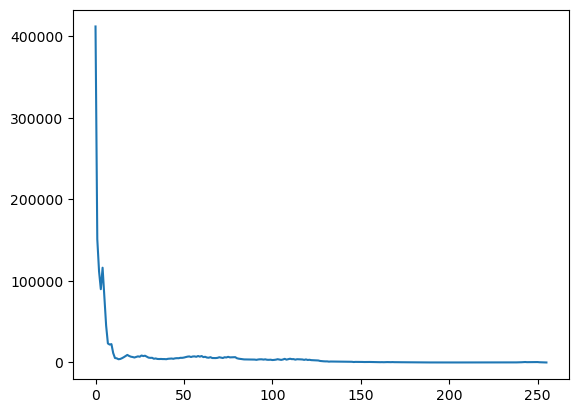

In [8]:
# Define where the sampling is done
split_sampling = 'training'

# Take % amount of samples of images from the training set to analyze
random.seed(642)
perc_samples = 0.25
n_samples = int(round(perc_samples*len(img_rel_paths_dict[split_sampling]), 0))
img_paths_analysis = random.sample(list(img_rel_paths_dict[split_sampling].keys()), n_samples)

# Read the images, preprocess and put both the source and the pre-processed image into a dictionary 
images = []
for img_key in img_paths_analysis:
    img_src = cv.imread(img_rel_paths_dict[split_sampling][img_key])
    images.append(img_src)

# The histogram for all images
hist = cv.calcHist(images, [0], None, [256], [0,256])
plt.plot(hist) 
plt.show()

### Analysis Per Image (Tests)

In [9]:
# Ranges from 1377 to 15610 for the Training Data
img_key = 3438
img_paths_analysis = img_rel_paths_dict['training']
img_path = img_paths_analysis[img_key]
img_src = cv.imread(img_path)
img_src = cv.cvtColor(img_src, cv.COLOR_BGR2GRAY)

# Image to use for the tests
img = np.copy(img_src)

# CLAHE
img_e = enhance_contrast_img(img, clipLimit=2, tileGridSize=(10, 10))

## Thresholding
# tc_s, img_thr = cv.threshold(img, 130, 255, cv.THRESH_BINARY) # Simple Thresholding
tc_o, img_thr_o = cv.threshold(img_e, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU) # Binary Thresholding through the Otsu method
img_thr_am = cv.adaptiveThreshold(img_e, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 27, 7) # Adaptive Thresholding Mean C
img_thr_g = cv.adaptiveThreshold(img_e, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 27, 7)  # Adaptive Thresholding Gaussian C

## Gaussian Blur
blur_amount = (25, 25)
blur_sd = 5

# Gaussian Blur applied to each thresholded image to smooth it
img_blur_o = cv.GaussianBlur(img_thr_o, blur_amount, blur_sd)
img_blur_am = cv.GaussianBlur(img_thr_am, blur_amount, blur_sd)

## Contouring
# Find the contours
contours_o, hier_o = cv.findContours(img_blur_o, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours_am, hier_am = cv.findContours(img_thr_am, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours_g, hier_g = cv.findContours(img_thr_g, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Overlay the found contours on the original image
img_contour_o = np.copy(img_e)
img_contour_o = cv.cvtColor(img_contour_o, cv.COLOR_GRAY2BGR)
# cv.drawContours(img_contour_o, contours_o, -1, (0, 137, 0), -1)

img_contour_am = np.copy(img_e)
img_contour_am = cv.cvtColor(img_contour_am, cv.COLOR_GRAY2BGR)
cv.drawContours(img_contour_am, contours_am, -1, (0, 137, 0), -1)

img_contour_g = np.copy(img_e)
img_contour_g = cv.cvtColor(img_contour_g, cv.COLOR_GRAY2BGR)
cv.drawContours(img_contour_g, contours_g, -1, (0, 137, 0), -1)

# for contour in contours_o:
#     Approximate the contour with a polygon
#     approx = cv.approxPolyDP(contour, 0.01 * cv.arcLength(contour, True), True)
#     if len(approx) == 4:
#         If the contour has 4 corners, it is a rectangle
#         cv.drawContours(img_contour_o, [approx], 0, (0, 255, 0), 2)

# Find the largest contour
largest_contour = max(contours_o, key=cv.contourArea)

# Get the bounding box around the largest contour
x, y, w, h = cv.boundingRect(largest_contour)

# # Add padding to the bounding box
# padding = 50
# x -= padding
# y -= padding
# w += 2 * padding
# h += 2 * padding

# # Ensure that the bounding box stays within the image bounds
# x = max(0, x)
# y = max(0, y)
# w = min(img.shape[1] - x, w)
# h = min(img.shape[0] - y, h)

# Crop the image to only keep the hand
img_contour_o = img_contour_o[y:y+h, x:x+w]


In [52]:
img_rel_paths_dict['training'].keys()

dict_keys([10000, 10001, 10002, 10003, 10004, 10005, 10006, 10007, 10008, 10009, 10010, 10011, 10012, 10013, 10014, 10015, 10016, 10017, 10019, 10020, 10021, 10022, 10023, 10024, 10025, 10026, 10029, 10030, 10031, 10033, 10035, 10036, 10037, 10038, 10039, 10040, 10041, 10042, 10043, 10044, 10045, 10046, 10047, 10048, 10049, 10051, 10052, 10053, 10054, 10055, 10056, 10057, 10058, 10059, 10060, 10061, 10062, 10063, 10064, 10066, 10067, 10068, 10069, 10070, 10071, 10073, 10074, 10075, 10076, 10077, 10078, 10079, 10080, 10081, 10083, 10084, 10085, 10086, 10087, 10088, 10089, 10090, 10091, 10092, 10093, 10094, 10095, 10096, 10097, 10099, 10100, 10102, 10103, 10104, 10105, 10106, 10107, 10108, 10109, 10110, 10111, 10112, 10113, 10114, 10115, 10116, 10117, 10118, 10120, 10121, 10122, 10123, 10125, 10126, 10128, 10130, 10131, 10132, 10134, 10136, 10137, 10138, 10139, 10140, 10141, 10143, 10144, 10145, 10146, 10147, 10148, 10149, 10150, 10151, 10152, 10153, 10154, 10155, 10156, 10157, 10158, 10

C:\Users\andresespinalh\AppData\Local\Temp\ipykernel_2400\4260202041.py:4: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  imgs_test = random.sample(img_rel_paths_dict['training'].keys(), 10)


[[   7.732994  174.68591 ]
 [1095.7257     22.308716]
 [1322.5153   1641.6156  ]
 [ 234.52258  1793.9928  ]]
[[ 234.52258  1793.9928  ]
 [   7.732994  174.68591 ]
 [1095.7257     22.308716]
 [1322.5153   1641.6156  ]]
Image: 10159
Original Resolution (1727, 1248)
Crop Resolution (1098, 1635)


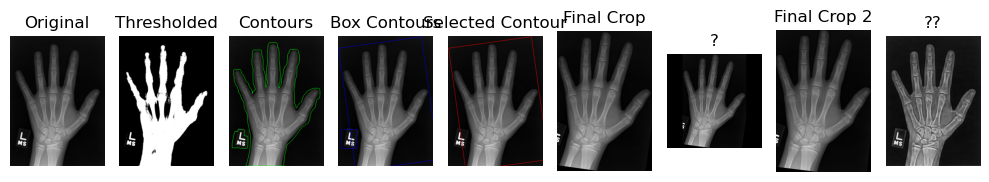

[[ 220.84741   160.18585 ]
 [1198.4877     62.489807]
 [1387.4667   1953.5945  ]
 [ 409.82642  2051.2905  ]]
[[ 409.82642  2051.2905  ]
 [ 220.84741   160.18585 ]
 [1198.4877     62.489807]
 [1387.4667   1953.5945  ]]
Image: 11453
Original Resolution (2014, 1400)
Crop Resolution (982, 1900)


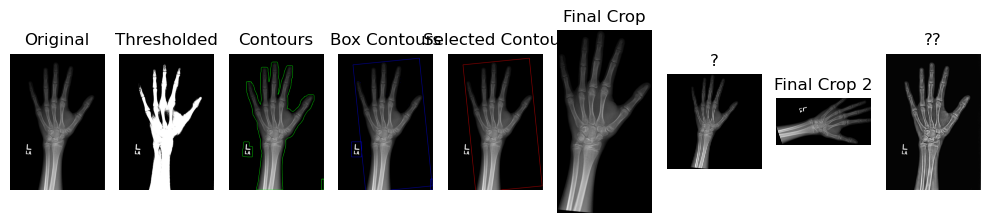

[[-5.1220855e-14  0.0000000e+00]
 [ 1.0770000e+03  0.0000000e+00]
 [ 1.0770000e+03  1.6730000e+03]
 [ 0.0000000e+00  1.6730000e+03]]
[[ 0.0000000e+00  1.6730000e+03]
 [-5.1220855e-14  0.0000000e+00]
 [ 1.0770000e+03  0.0000000e+00]
 [ 1.0770000e+03  1.6730000e+03]]
Image: 15425
Original Resolution (1674, 1078)
Crop Resolution (1077, 1673)


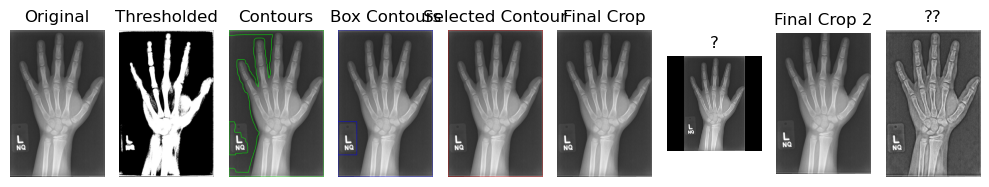

[[  44.107025  156.30481 ]
 [ 872.8313      4.180298]
 [1108.4268   1287.6271  ]
 [ 279.7025   1439.7516  ]]
[[ 279.7025   1439.7516  ]
 [  44.107025  156.30481 ]
 [ 872.8313      4.180298]
 [1108.4268   1287.6271  ]]
Image: 9387
Original Resolution (1377, 1030)
Crop Resolution (842, 1304)


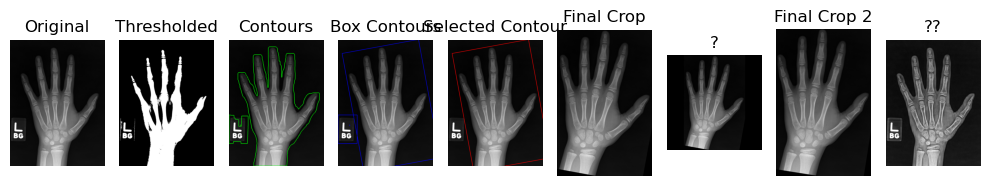

[[ 282.91687  147.9939 ]
 [1355.8226    45.40918]
 [1501.7374  1571.4937 ]
 [ 428.83167 1674.0784 ]]
[[ 428.83167 1674.0784 ]
 [ 282.91687  147.9939 ]
 [1355.8226    45.40918]
 [1501.7374  1571.4937 ]]
Image: 14085
Original Resolution (1635, 1546)
Crop Resolution (1077, 1533)


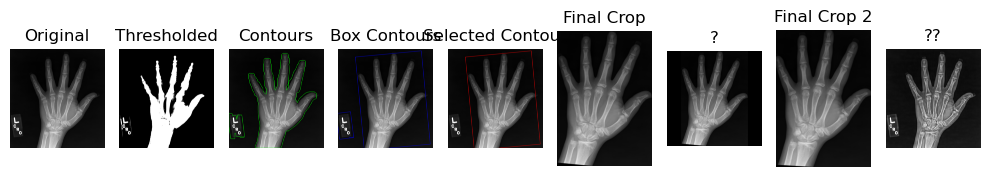

[[ 221.98228    123.47412  ]
 [1252.8363       7.4033203]
 [1458.3141    1832.3018   ]
 [ 427.46008   1948.3726   ]]
[[ 427.46008   1948.3726   ]
 [ 221.98228    123.47412  ]
 [1252.8363       7.4033203]
 [1458.3141    1832.3018   ]]
Image: 12350
Original Resolution (1892, 1377)
Crop Resolution (1037, 1836)


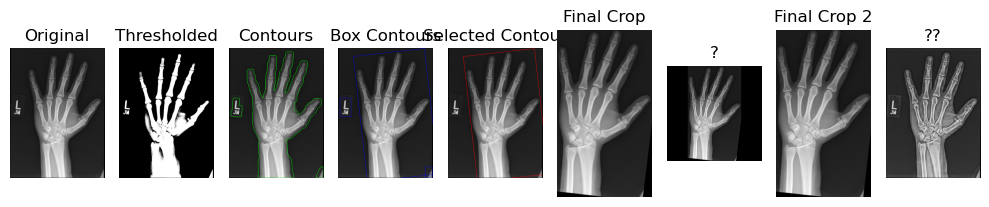

[[-159.845   1086.0876 ]
 [ 240.22849  -91.31511]
 [1023.6034   174.87036]
 [ 623.5299  1352.2731 ]]
[[ 623.5299  1352.2731 ]
 [-159.845   1086.0876 ]
 [ 240.22849  -91.31511]
 [1023.6034   174.87036]]
Image: 14007
Original Resolution (1243, 1012)
Crop Resolution (1243, 827)


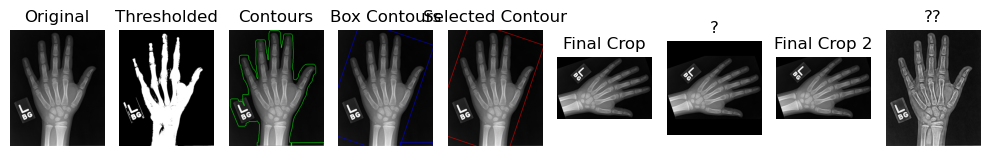

[[ 222.6033    125.60681 ]
 [1199.176     -18.840942]
 [1414.051    1433.8718  ]
 [ 437.47827  1578.3196  ]]
[[ 437.47827  1578.3196  ]
 [ 222.6033    125.60681 ]
 [1199.176     -18.840942]
 [1414.051    1433.8718  ]]
Image: 14477
Original Resolution (1522, 1351)
Crop Resolution (987, 1468)


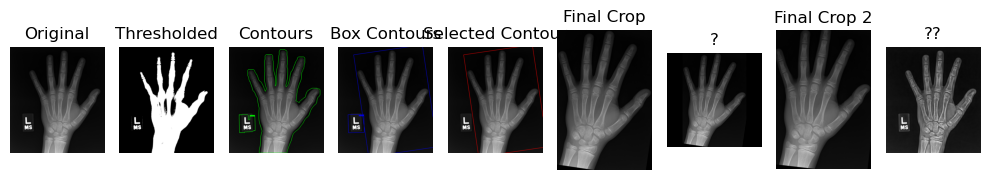

[[  24.640472  101.154785]
 [ 926.8303     10.248291]
 [1107.2767   1801.0653  ]
 [ 205.08691  1891.9718  ]]
[[ 205.08691  1891.9718  ]
 [  24.640472  101.154785]
 [ 926.8303     10.248291]
 [1107.2767   1801.0653  ]]
Image: 13398
Original Resolution (1803, 1099)
Crop Resolution (906, 1799)


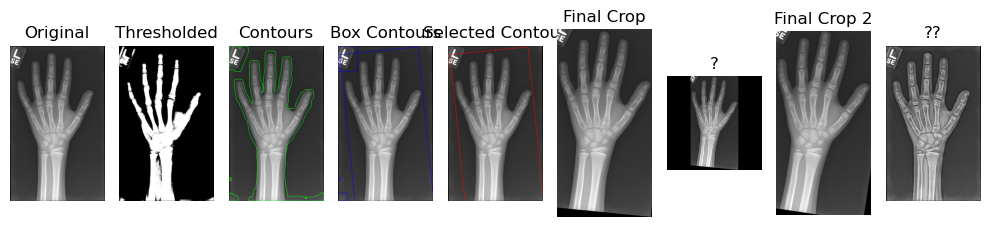

[[ 125.09558  2385.1367  ]
 [ 199.65588    61.881134]
 [1743.8103    111.437744]
 [1669.25     2434.6934  ]]
[[1669.25     2434.6934  ]
 [ 125.09558  2385.1367  ]
 [ 199.65588    61.881134]
 [1743.8103    111.437744]]
Image: 1932
Original Resolution (2570, 2040)
Crop Resolution (2324, 1544)


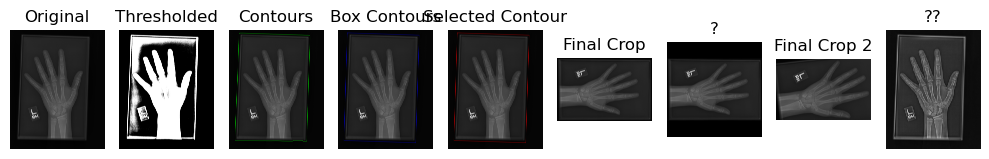

In [162]:
img_paths_analysis = img_rel_paths_dict['training']
# imgs_test = [1378, 1379, 1381, 1435, 1430, 3000, 3001, 3213, 3438, 3476]
random.seed(206)
imgs_test = random.sample(img_rel_paths_dict['training'].keys(), 10)

for img_key in imgs_test:
    img_path = img_paths_analysis[img_key]
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_e = enhance_contrast_img(img, clipLimit=2, tileGridSize=(10, 10))

    # First perform Binary Thresholding through the Otsu method
    tc_o, img_thr_o = cv.threshold(img_e, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    # Apply a Gaussian Blur
    img_blur_o = cv.GaussianBlur(img_thr_o, (71, 71), 333)

    # Find all contours on the blurred image
    contours_o, hier_o = cv.findContours(img_blur_o, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Draw Original Contours
    img_c = np.copy(img)
    img_c = cv.cvtColor(img_c, cv.COLOR_GRAY2BGR)
    cv.drawContours(img_c, contours_o, -1, (0, 255, 0), 3)

    # Draw boxed contours
    img_box = np.copy(img)
    img_box = cv.cvtColor(img_box, cv.COLOR_GRAY2BGR)

    for contour in contours_o:
        rect = cv.minAreaRect(contour)
        box = cv.boxPoints(rect)
        cv.drawContours(img_box, [np.int0(box)], 0, (255, 0, 0), 3)

    # Select only the outermost contour
    largest_contour = max(contours_o, key=cv.contourArea)

    # Get the rotated bounding box of the largest contour
    rect = cv.minAreaRect(largest_contour)
    box = cv.boxPoints(rect)

    # Draw the selected boxed contour
    img_rot = np.copy(img)
    img_rot = cv.cvtColor(img_rot, cv.COLOR_GRAY2BGR)
    cv.drawContours(img_rot, [np.int0(box)], 0, (0, 0, 255), 3)

    # Get the proportion of the total area of the image from the outermost contour
    img_tot_pixels = img.shape[0]*img.shape[1]
    contour_perc = cv.contourArea(largest_contour)/img_tot_pixels

    print(box)
    print(np.roll(box, 1, axis=0))

    # If the contour found is composed by a percentage bigger than the threshold, perform the crop. Otherwise leave the image as it is
    if(contour_perc > 0.10):
        # Get a bounding box representing the outermost rectangle
        x, y, w, h = cv.boundingRect(box)

        # Get the center of the bounding box
        center = (x + w // 2, y + h // 2)

        # Define a set of points that represent the x-axis and y-axis in the bounding box
        # NOTE: Indexing of the rectangle starts on the bottom left corner (Index 0) and ends on the top left corner (Index 3)
        p1_x, p2_x, p1_y, p2_y = box[0], box[1], box[0], box[3]

        # Calculate the distance between the points for the horizontal and vertical axis (This is the resolution of the box)
        res_x = int(np.sqrt(np.sum((p2_x - p1_x)**2)))
        res_y = int(np.sqrt(np.sum((p2_y - p1_y)**2)))

        size = (res_x, res_y)
        

        # Get the rotation matrix for rotating the image
        M = cv.getPerspectiveTransform(box, np.array([[0, 0], [res_x, 0], [res_x, res_y], [0, res_y]], dtype=np.float32))

        # Crop the image based on the perspective transform matrix
        img_p = cv.warpPerspective(img, M, size) 
    else:
        img_p = img

    # Compute the mean color of the border pixels of the rectangular image
    h, w = img_p.shape[:2]
    max_side = max(h, w)
    square_img = np.zeros((max_side, max_side), np.uint8)
    start_row = int((max_side - h) / 2)
    start_col = int((max_side - w) / 2)
    square_img[start_row:start_row + h, start_col:start_col + w] = img_p

    # img_p_e = enhance_contrast_img(img_p, clipLimit=2, tileGridSize=(10, 10))
    print('Image: {0}'.format(img_key))
    print('Original Resolution ({0}, {1})'.format(img.shape[0], img.shape[1]))
    print('Crop Resolution ({0}, {1})'.format(res_x, res_y))
    imgs_comp = [img, img_thr_o, img_c, img_box, img_rot, img_p, square_img, crop_img_angled(img), preprocess_image(img, 'clahecropfill_r250')]
    labels = ['Original', 'Thresholded', 'Contours', 'Box Contours', 'Selected Contour', 'Final Crop', '?', 'Final Crop 2', '??']
    display_img_comp(imgs_comp, labels)

Image Analyzed: 2887


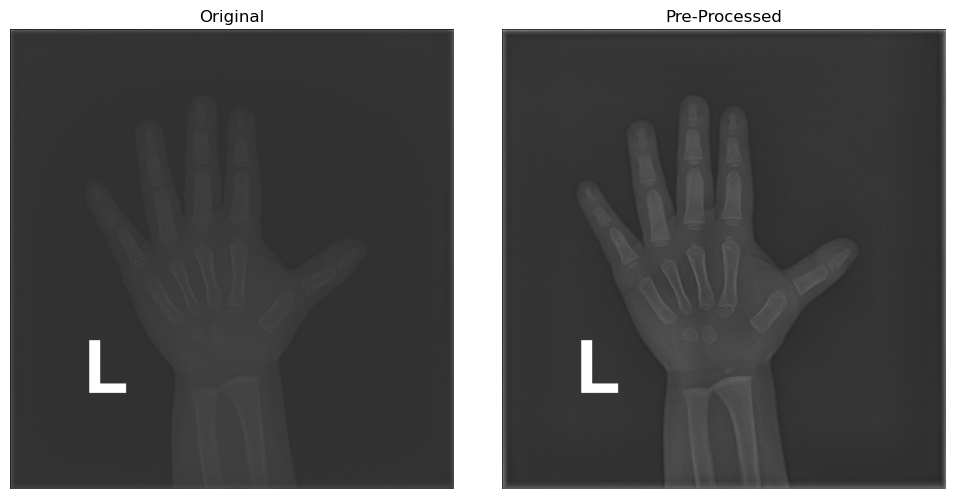

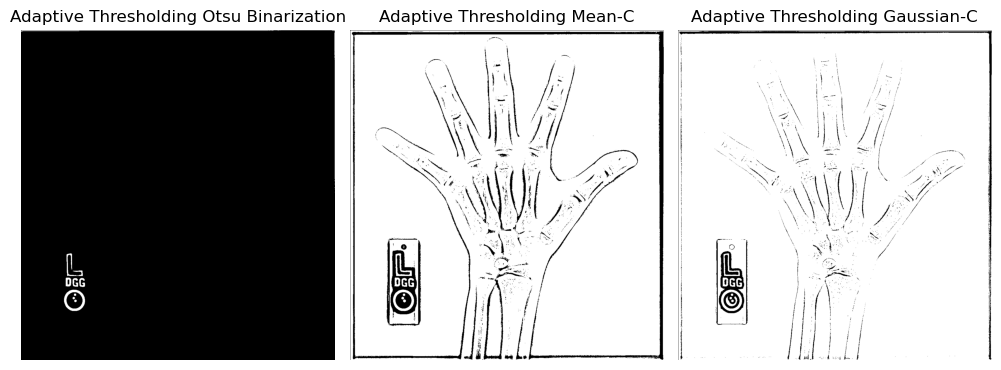

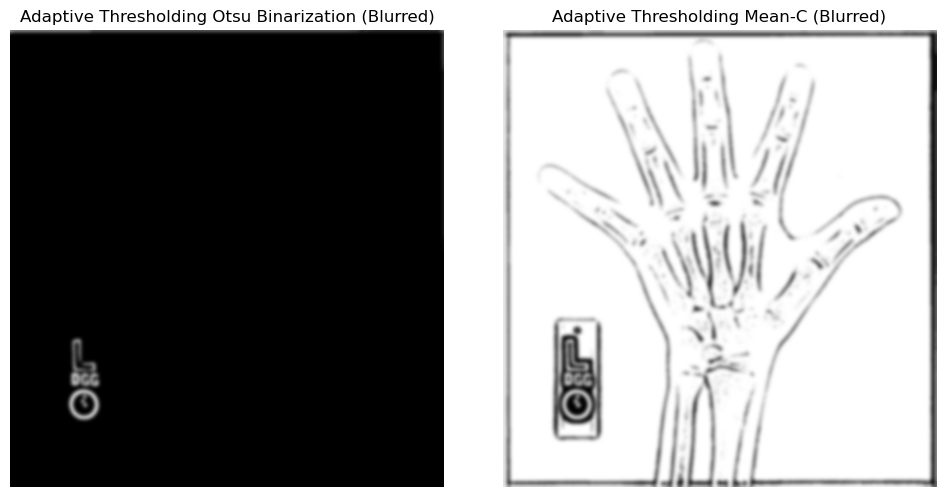

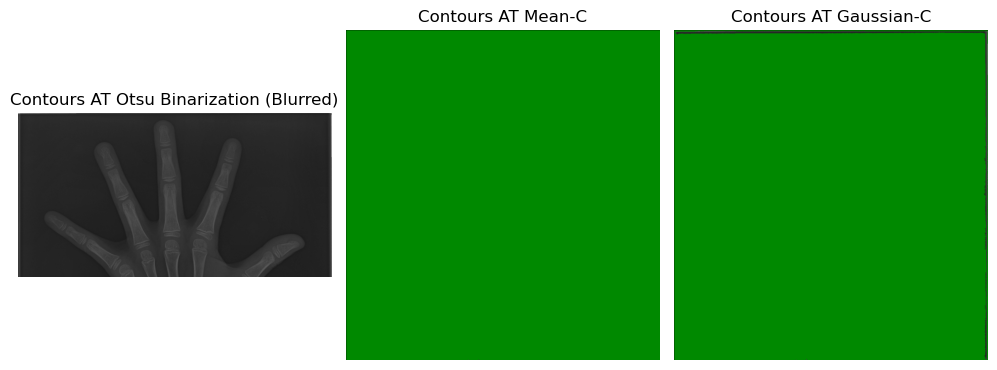

In [256]:
print('Image Analyzed: {0}'.format(img_key))

# Original vs. Processed
imgs_comp = [img, img_e]
labels = ['Original', 'Pre-Processed']
display_img_comp(imgs_comp, labels)

# Thresholding
imgs_comp = [img_thr_o, img_thr_am, img_thr_g]
labels = ['Adaptive Thresholding Otsu Binarization', 'Adaptive Thresholding Mean-C', 'Adaptive Thresholding Gaussian-C']
display_img_comp(imgs_comp, labels)

# Blurring
imgs_comp = [img_blur_o, img_blur_am]
labels = ['Adaptive Thresholding Otsu Binarization (Blurred)', 'Adaptive Thresholding Mean-C (Blurred)']
display_img_comp(imgs_comp, labels)

# Contours
imgs_comp = [img_contour_o, img_contour_am, img_contour_g]
labels = ['Contours AT Otsu Binarization (Blurred)', 'Contours AT Mean-C', 'Contours AT Gaussian-C']
display_img_comp(imgs_comp, labels)


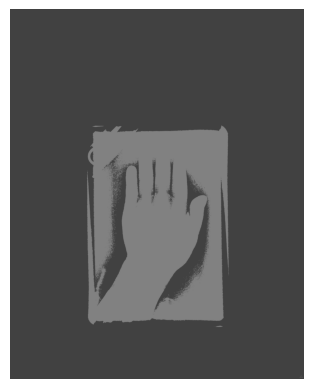

In [229]:
## K-Means Segmentation
img_km = np.copy(img_e)
# img_km = np.copy(img_blur_o)

# ## Gaussian Blur
# img_blur = cv.GaussianBlur(img_km, (1, 1), 1)

# Since the image is in grayscale (1 Channel) we only accomodate the rows into 1 column
img_reshaped = img_km.reshape((-1,1))
img_reshaped = np.float32(img_reshaped)

# Number of clusters
k = 2

# Clustering
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret, label, center = cv.kmeans(img_reshaped, k, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

# Assign labels to each pixel
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

display_img(res2)